# Capstone Project - Locations for Sports Stores in Brooklyn, NY

## Business Problem
Goal of this project is to find the best location/neighborhood for new sports equipment shops in Brooklyn, NY. The citeria for a good neighborhood are that it should be located in a neighborhood with a high density of gyms, sports stadiums, baseball fields, and all sports-related venues indeed, in order to attract the highest possible amount of customers. However, the customer also wants to know about neighborhood classifications in terms of what types of sports venues are, so he can open up the right type of sports shop in the right neighborhood (i.e. a personal fitness store in a neighborhood with a high amount of gyms, or a team sport store where many people are witnessed playing basketball, soccer, etc.)

## Data and Procedure
The data provided is of geographical nature (coordinates) regarding the neighborhoods, and also venue-related (categories, locations, etc.). First, I will retrieve the geographical data, store in a data frame and reduce it to the relevant Brooklyn content. Then, I will use the folium package to visualize the relevant neighborhoods in Brooklyn. The venue data will be analyzed regarding the discussed target venues and assessed in terms of the highest amount of sports venues. Finally, the neighborhoods will be classified into clusters that appropriately represent the types of sports venues, so one can make recommendations as to which type of stores should be opened in which neighborhoods.

## Data Wrangling and Initial Exploration

In [1]:
# import dependencies
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

    neighborhoods_data = newyork_data['features']

Transform the data into a DataFrame

In [3]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Use geopy library to get the latitude and longitude values

In [4]:
address = 'Brooklyn, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Reduce the DataFrame to Brooklyn-related data

In [5]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [6]:
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Foursquare is used to retrieve venue data

In [7]:
CLIENT_ID = 'DRABCEZ3UYP5T5WJHSFYRBC0XTZ0BTMZE1GWJDBRE4MEP13G' # your Foursquare ID
CLIENT_SECRET = '42DE0DPWGZYPLWZMCHMBRXNRMZNKEDLIUL4YECKRYQI33E4P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Explore Neighborhoods in Brooklyn

In [8]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,The Bookmark Shoppe,40.624577,-74.030562,Bookstore


In [9]:
venue_categories = brooklyn_venues['Venue Category'].unique()
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 283 uniques categories.


Filter out all venue categories that are related to restaurants for better overview

In [10]:
filter_words = 'Restaurant'
filtered_venues = []

for v in venue_categories:
    if filter_words not in v:
        filtered_venues.append(v)
filtered_venues

['Spa',
 'Bagel Shop',
 'Pizza Place',
 'Breakfast Spot',
 'Bookstore',
 'Taco Place',
 'Juice Bar',
 'Grocery Store',
 'Sports Bar',
 'Bar',
 'Coffee Shop',
 'Optical Shop',
 'Lounge',
 'Hookah Bar',
 'Tea Room',
 'Ice Cream Shop',
 'Café',
 'Toy / Game Store',
 'Department Store',
 'Video Game Store',
 'Lingerie Store',
 'Kids Store',
 'Sandwich Place',
 'Gym / Fitness Center',
 'Clothing Store',
 'Snack Place',
 'Pharmacy',
 'Mobile Phone Shop',
 'Pool Hall',
 'Mattress Store',
 'Supermarket',
 'Hotel',
 'Yoga Studio',
 'Diner',
 'Karaoke Bar',
 'Playground',
 'Park',
 'Cosmetics Shop',
 'Bakery',
 'Butcher',
 'Liquor Store',
 'Noodle House',
 'Donut Shop',
 'Flower Shop',
 'Road',
 'Bridal Shop',
 'Sporting Goods Shop',
 'Cha Chaan Teng',
 'Bank',
 'Fried Chicken Joint',
 'Creperie',
 'Record Shop',
 'Gym',
 'Supplement Shop',
 "Women's Store",
 'Deli / Bodega',
 'Laundry Service',
 'Gymnastics Gym',
 'Gastropub',
 'Furniture / Home Store',
 'Cocktail Bar',
 'Beer Store',
 'Boutiqu

The following venue categories are manually selected to be sports-related:

In [11]:
sports_venues = ['Gym / Fitness Center', 'Yoga Studio', 'Park', 'Gym', 'Gymnastics Gym', 'Beach','Cycle Studio',
    'Tennis Court','Pool','Skating Rink','Baseball Stadium','Surf Spot','Golf Course',
    'Basketball Court', 'Soccer Field','Boxing Gym','Ski Area','Field','Climbing Gym']

In [12]:
brooklyn_sports_venues = brooklyn_venues[brooklyn_venues['Venue Category'].isin(sports_venues)].reset_index(drop=True)
brooklyn_sports_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,New York Sports Clubs,40.622364,-74.027163,Gym / Fitness Center
1,Bay Ridge,40.625801,-74.030621,Dahn Yoga,40.626273,-74.030208,Yoga Studio
2,Bay Ridge,40.625801,-74.030621,Fort Hamtilton Handball Court,40.625991,-74.036298,Park
3,Bensonhurst,40.611009,-73.995180,Park,40.610529,-73.994874,Park
4,Sunset Park,40.645103,-74.010316,Blink Fitness,40.645502,-74.013143,Gym


In [13]:
map_brooklyn_venues = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(brooklyn_sports_venues['Venue Latitude'], brooklyn_sports_venues['Venue Longitude'], brooklyn_sports_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn_venues)

for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn_venues) 
    
map_brooklyn_venues

### Analyze Neighborhoods

In [14]:
brooklyn_sports_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,New York Sports Clubs,40.622364,-74.027163,Gym / Fitness Center
1,Bay Ridge,40.625801,-74.030621,Dahn Yoga,40.626273,-74.030208,Yoga Studio
2,Bay Ridge,40.625801,-74.030621,Fort Hamtilton Handball Court,40.625991,-74.036298,Park
3,Bensonhurst,40.611009,-73.995180,Park,40.610529,-73.994874,Park
4,Sunset Park,40.645103,-74.010316,Blink Fitness,40.645502,-74.013143,Gym


In [15]:
brooklyn_onehot = pd.get_dummies(brooklyn_sports_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_sports_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Neighborhood,Baseball Stadium,Basketball Court,Beach,Boxing Gym,Climbing Gym,Cycle Studio,Field,Golf Course,Gym,Gym / Fitness Center,Gymnastics Gym,Park,Pool,Skating Rink,Ski Area,Soccer Field,Surf Spot,Tennis Court,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Bensonhurst,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Sunset Park,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
brooklyn_onehot['Neighborhood'].value_counts().to_frame().head()

,Neighborhood
Brooklyn Heights,15
Dumbo,13
South Side,9
North Side,9
Fulton Ferry,8


The 5 neighborhoods with the highest amount of sports venues can be seen above

In [17]:
brooklyn_grouped_sports = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped_sports.head(5)

,Neighborhood,Baseball Stadium,Basketball Court,Beach,Boxing Gym,Climbing Gym,Cycle Studio,Field,Golf Course,Gym,Gym / Fitness Center,Gymnastics Gym,Park,Pool,Skating Rink,Ski Area,Soccer Field,Surf Spot,Tennis Court,Yoga Studio
0,Bath Beach,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.5,0.000000,0.000000
1,Bay Ridge,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333
2,Bedford Stuyvesant,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,Bensonhurst,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,Boerum Hill,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.285714


Each neighborhood along with the top 3 most common sports venues

In [18]:
num_top_venues = 3

for hood in brooklyn_grouped_sports['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped_sports[brooklyn_grouped_sports['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
              venue  freq
0         Surf Spot   0.5
1              Park   0.5
2  Baseball Stadium   0.0


----Bay Ridge----
                  venue  freq
0  Gym / Fitness Center  0.33
1                  Park  0.33
2           Yoga Studio  0.33


----Bedford Stuyvesant----
              venue  freq
0              Park   1.0
1  Baseball Stadium   0.0
2    Gymnastics Gym   0.0


----Bensonhurst----
              venue  freq
0              Park   1.0
1  Baseball Stadium   0.0
2    Gymnastics Gym   0.0


----Boerum Hill----
                  venue  freq
0  Gym / Fitness Center  0.43
1           Yoga Studio  0.29
2          Tennis Court  0.14


----Brighton Beach----
              venue  freq
0             Beach   1.0
1  Baseball Stadium   0.0
2    Gymnastics Gym   0.0


----Brooklyn Heights----
         venue  freq
0  Yoga Studio  0.27
1         Park  0.27
2          Gym  0.20


----Brownsville----
              venue  freq
0              Park   1.0
1  Baseball Stadium   

top ten venues for each neighborhood

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 3
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped_sports['Neighborhood']

for ind in np.arange(brooklyn_grouped_sports.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped_sports.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bath Beach,Surf Spot,Park,Yoga Studio
1,Bay Ridge,Yoga Studio,Park,Gym / Fitness Center
2,Bedford Stuyvesant,Park,Yoga Studio,Gym
3,Bensonhurst,Park,Yoga Studio,Gym
4,Boerum Hill,Gym / Fitness Center,Yoga Studio,Boxing Gym


### Clustering of Neighborhoods by sports-related venues

In [20]:
kclusters = 10
sse = []
brooklyn_grouped_sports_clustering = brooklyn_grouped_sports.drop('Neighborhood', 1)

for k in range(1,kclusters):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(brooklyn_grouped_sports_clustering)
    sse.append(kmeans.inertia_)

Use of 'elbow method' to determine best number of clusters

(0, 29.576947105925143)

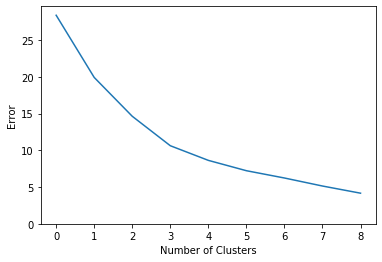

In [21]:
import matplotlib.pyplot as plt
plt.plot(sse)
plt.xlabel('Number of Clusters')
plt.ylabel('Error')
plt.ylim(0,)

No clear best fit is apparent, but k = 3 appears to be suitable

In [22]:
kclusters = 3
brooklyn_grouped_sports_clustering = brooklyn_grouped_sports.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(brooklyn_grouped_sports_clustering)

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
brooklyn_merged = brooklyn_data

# merge brooklyn_grouped with brooklyn_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0.0,Yoga Studio,Park,Gym / Fitness Center
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1.0,Park,Yoga Studio,Gym
2,Brooklyn,Sunset Park,40.645103,-74.010316,2.0,Gym,Yoga Studio,Basketball Court
3,Brooklyn,Greenpoint,40.730201,-73.954241,0.0,Yoga Studio,Gymnastics Gym,Gym
4,Brooklyn,Gravesend,40.595260,-73.973471,2.0,Gym,Yoga Studio,Basketball Court
...,...,...,...,...,...,...,...,...
65,Brooklyn,Dumbo,40.703176,-73.988753,0.0,Park,Yoga Studio,Gym
66,Brooklyn,Homecrest,40.598525,-73.959185,NaN,NaN,NaN,NaN
67,Brooklyn,Highland Park,40.681999,-73.890346,0.0,Gym / Fitness Center,Park,Tennis Court
68,Brooklyn,Madison,40.609378,-73.948415,NaN,NaN,NaN,NaN


some neighborhoods do not contain any sports venues, so they need to be excluded from the analysis

In [24]:
brooklyn_merged.dropna(axis=0, inplace=True)

### Visualization of Clusters

In [25]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Interpretation of the Results

In [26]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bay Ridge,Yoga Studio,Park,Gym / Fitness Center
3,Greenpoint,Yoga Studio,Gymnastics Gym,Gym
5,Brighton Beach,Beach,Yoga Studio,Gym
6,Sheepshead Bay,Yoga Studio,Gym,Basketball Court
15,Williamsburg,Yoga Studio,Gym,Park
18,Brooklyn Heights,Yoga Studio,Park,Gym
19,Cobble Hill,Yoga Studio,Park,Gym / Fitness Center
20,Carroll Gardens,Gym / Fitness Center,Park,Gym
22,Gowanus,Gym / Fitness Center,Park,Yoga Studio
23,Fort Greene,Yoga Studio,Park,Tennis Court


In [27]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Bensonhurst,Park,Yoga Studio,Gym
10,East Flatbush,Park,Yoga Studio,Gym
11,Kensington,Park,Yoga Studio,Gym
12,Windsor Terrace,Park,Yoga Studio,Gym
14,Brownsville,Park,Yoga Studio,Gym
17,Bedford Stuyvesant,Park,Yoga Studio,Gym
21,Red Hook,Park,Yoga Studio,Gym
29,Flatlands,Park,Yoga Studio,Gym
33,Bath Beach,Surf Spot,Park,Yoga Studio
35,Dyker Heights,Park,Golf Course,Yoga Studio


In [28]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,Sunset Park,Gym,Yoga Studio,Basketball Court
4,Gravesend,Gym,Yoga Studio,Basketball Court
16,Bushwick,Gym,Yoga Studio,Basketball Court
26,East New York,Gym,Yoga Studio,Basketball Court
28,Canarsie,Gym,Yoga Studio,Basketball Court
57,Remsen Village,Gym,Yoga Studio,Basketball Court


### Identified types of clusters:
- 0: high amount of yoga studios and good amount of gyms (red)
- 1: Outdoor and Park neighborhoods with a good amount of yoga studios (purple)
- 2: high concentration of gyms with a good amount of yoga studios (green)


## Conclusion

The neighborhoods in Brooklyn with the highest amount of sports venues are Brooklyn Heights, Dumbo, North Side, South Side and Fulton Ferry. Sports equipment shops will most likely attract the most attention if opened in one of these neighborhoods. Furthermore, they are all very close to Manhattan.

All neighborhoods with sports venues in Brooklyn can be clustered into three groups: 
- 0: miscellaneous (red)
- 1: Outdoor and Park (purple)
- 2: Gym and Yoga (green)

Four of the mentioned top 5 neighborhoods fall into the category 'miscellaneous', while Fulton Ferry is characterized as a Outdoor and Park neighborhood. The table below indicates, however, that there is a very high proportion of yoga studios (but also gyms) in those neighborhoods, so an equipment store related to these categories would be suggestable. 

In [29]:
top_5 = ['Brooklyn Heights', 'Dumbo', 'North Side', 'South Side', 'Fulton Ferry']
brooklyn_merged_top_5 = brooklyn_merged[brooklyn_merged['Neighborhood'].isin(top_5)]
brooklyn_merged_top_5

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
18,Brooklyn,Brooklyn Heights,40.695864,-73.993782,0.0,Yoga Studio,Park,Gym
50,Brooklyn,North Side,40.714823,-73.958809,0.0,Yoga Studio,Cycle Studio,Gym
51,Brooklyn,South Side,40.710861,-73.958001,0.0,Yoga Studio,Cycle Studio,Park
61,Brooklyn,Fulton Ferry,40.703281,-73.995508,1.0,Park,Beach,Yoga Studio
65,Brooklyn,Dumbo,40.703176,-73.988753,0.0,Park,Yoga Studio,Gym


In [37]:
map_clusters_final = folium.Map(location=[latitude, longitude], zoom_start=12)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged_top_5['Latitude'], brooklyn_merged_top_5['Longitude'], brooklyn_merged_top_5['Neighborhood'], brooklyn_merged_top_5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_final)
       
map_clusters_final